In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Exploratory Data Analysis

In [3]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import os

from src.data.loaders import get_loader
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
metadata = pl.read_parquet('./data/raw_parquet/macho/metadata.parquet')

In [4]:
scan = pl.scan_parquet('./data/raw_parquet/macho/light_curves/*.parquet')

In [5]:
scan.columns

['mjd', 'mag', 'errmag', 'newID', '__index_level_0__']

In [6]:
def get_snr(inputs):
    f0 = 1.
    inputs = inputs.sort('mjd', descending=True) 
    
    p99 = inputs.quantile(0.99, 'nearest')
    p01 = inputs.quantile(0.01, 'nearest')
    inputs = inputs.filter(pl.col('mag') < p99['mag'])
    inputs = inputs.filter(pl.col('mag') > p01['mag'])

    inputs = inputs.with_columns(
        (f0 * 10 ** (-pl.col('mag') / 2.5)).alias('flux')  
    )   
    
    inputs = inputs.with_columns(
        (f0 * 10 ** (-pl.col('errmag') / 2.5)).alias('errflux')  
    )    
    return inputs

In [7]:
sma = {
    'mjd': pl.Float64, 
    'mag': pl.Float64, 
    'newID': pl.Int64,
    'flux': pl.Float64,
    'errflux': pl.Float64,
    'snr_sqrt': pl.Float64,
    'snr_std': pl.Float64,
    'snr_err': pl.Float64,
    '__index_level_0__': pl.Int64
}

err_filtering = (pl.col('errmag') < 1) & (pl.col('errmag') > 0)
pscan = scan.filter(err_filtering).drop_nulls().group_by('newID')


ske = pl.col("flux").skew().alias('skew')
kur = pl.col("flux").kurtosis().alias('kur')
std = pl.col("flux").std().alias('std')

snr = (pl.mean("flux")/pl.mean("flux").sqrt()).alias('snr_sqrt')
snr_2 = (pl.mean("flux")/pl.std("flux")).alias('snr_std')
snr_3 = (pl.mean("flux")/pl.std("errflux")).alias('snr_err')

pscan = pscan.map_groups(lambda lc: get_snr(lc), schema=sma).group_by('newID').agg([snr, snr_2, snr_3, ske, kur, std])

In [8]:
%%time
new_features = pscan.collect()

CPU times: user 8h 45min 5s, sys: 1h 1min 19s, total: 9h 46min 25s
Wall time: 27min 15s


In [9]:
%%time
new_metadata = metadata.join(new_features, on='newID')

CPU times: user 775 ms, sys: 550 ms, total: 1.33 s
Wall time: 338 ms


In [10]:
new_metadata_pandas = new_metadata.to_pandas()

In [11]:
new_metadata_pandas.to_parquet('./data/raw_parquet/macho/metadata_ext.parquet', index=False)

In [12]:
new_metadata_pandas['skew']

0         -1.927339
1          0.737107
2         -2.029344
3         -1.087248
4         -0.651482
             ...   
1529313    1.911926
1529314    2.988482
1529315    1.182601
1529316    3.004389
1529317    2.147688
Name: skew, Length: 1529318, dtype: float64

### Raw stats

0 snr_std
1 kur
2 skew


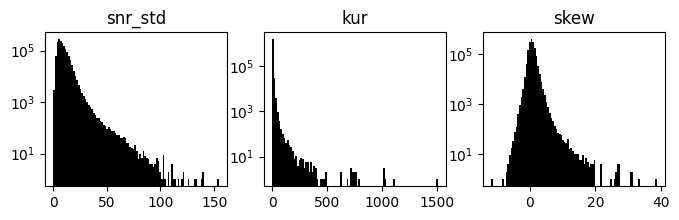

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2))
for i, col in enumerate(['snr_std', 'kur', 'skew']):
    print(i, col)
    axes[i].hist(new_metadata_pandas[col], color='k', bins=100)
    axes[i].set_yscale('log')
    axes[i].set_title(col)
plt.show()

## Filtering by kurtosis and skewness 

In [40]:
filtered = new_metadata_pandas[(new_metadata_pandas['skew'].abs() > 1.) & \
                                (new_metadata_pandas['kur'].abs() > 10.) & \
                                (new_metadata_pandas['std'].abs() > .1)]

0 snr_std
1 kur
2 skew


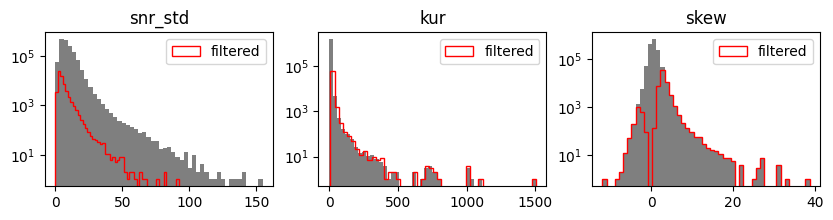

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2))
for i, col in enumerate(['snr_std', 'kur', 'skew']):
    print(i, col)
    axes[i].hist(new_metadata_pandas[col], color='k', bins=50, alpha=0.5)
    axes[i].hist(filtered[col], color='r', bins=50, fill=False, histtype='step', label='filtered')
    axes[i].set_yscale('log')
    axes[i].set_title(col)
    axes[i].legend()
plt.show()

## Comparing High and Low S/N 

In [42]:
scan = pl.scan_parquet('./data/raw_parquet/macho/light_curves/*.parquet')

In [48]:
new_metadata_pandas = new_metadata_pandas.sort_values('snr_sqrt', ascending=False)
new_metadata_pandas= new_metadata_pandas.fillna(0.)

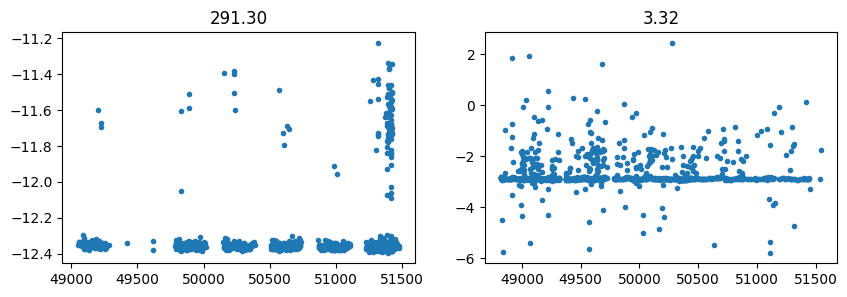

In [50]:
N0 = np.random.randint(0, 20)
N1 = np.random.randint(new_metadata_pandas.shape[0]-50, new_metadata_pandas.shape[0])

lc_high_snr = scan.filter(pl.col('newID') == new_metadata_pandas.iloc[N0].newID).collect()
lc_low_snr = scan.filter(pl.col('newID') == new_metadata_pandas.iloc[N1].newID).collect()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].errorbar(lc_high_snr['mjd'], lc_high_snr['mag'], linestyle='', marker='.')
axes[0].set_title('{:.2f}'.format(new_metadata_pandas.iloc[N0]['snr_sqrt']))
axes[1].errorbar(lc_low_snr['mjd'], lc_low_snr['mag'], linestyle='', marker='.')
axes[1].set_title('{:.2f}'.format(new_metadata_pandas.iloc[N1]['snr_sqrt']))
plt.show()

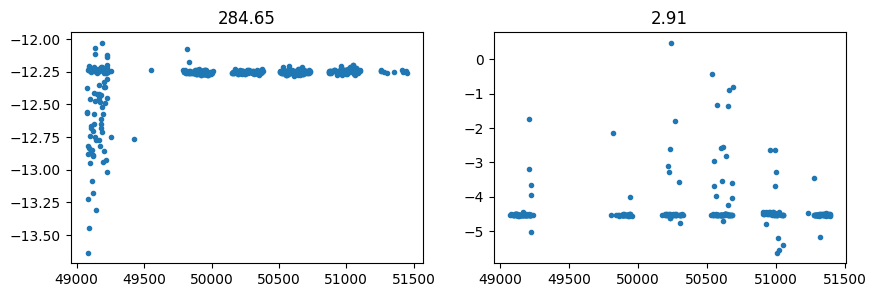

In [64]:
N0 = np.random.randint(0, 20)
N1 = np.random.randint(new_metadata_pandas.shape[0]-50, new_metadata_pandas.shape[0])

lc_high_snr = scan.filter(pl.col('newID') == new_metadata_pandas.iloc[N0].newID).collect()
lc_low_snr = scan.filter(pl.col('newID') == new_metadata_pandas.iloc[N1].newID).collect()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].errorbar(lc_high_snr['mjd'], lc_high_snr['mag'], linestyle='', marker='.')
axes[0].set_title('{:.2f}'.format(new_metadata_pandas.iloc[N0]['snr_sqrt']))
axes[1].errorbar(lc_low_snr['mjd'], lc_low_snr['mag'], linestyle='', marker='.')
axes[1].set_title('{:.2f}'.format(new_metadata_pandas.iloc[N1]['snr_sqrt']))
plt.show()

## Selecting object for records metadata

In [9]:
new_metadata_pandas = pl.read_parquet('./data/raw_parquet/macho/metadata_ext.parquet').to_pandas()
new_metadata_pandas = new_metadata_pandas.sort_values('snr_sqrt', ascending=False)

In [50]:
dataset = get_loader('/home/users/cdonoso/astromer/data/records/macho/test/',
                       batch_size=64,
                       window_size=200,
                       probed_frac=.2,
                       random_frac=.1,
                       same_frac=None,
                       sampling=True,
                       shuffle=False,
                       repeat=1,
                       num_cls=None,
                       normalize='zero-mean',
                       cache=False,
                       aversion='base')

[INFO] Probed: 0.20 Random: 0.10 Same: 0.10
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows


In [51]:
oids = np.concatenate([y['lcid'] for x, y in dataset])
oids = [x.decode("utf-8") for x in oids]

In [55]:
test_meta = new_metadata_pandas[new_metadata_pandas['ID'].isin(oids)]
rest = new_metadata_pandas[~new_metadata_pandas['ID'].isin(test_meta['ID']) ]
test_meta.to_parquet('./data/raw_parquet/macho/test_metadata.parquet')

In [56]:
rest.shape, test_meta.shape

((1376385, 16), (152933, 16))

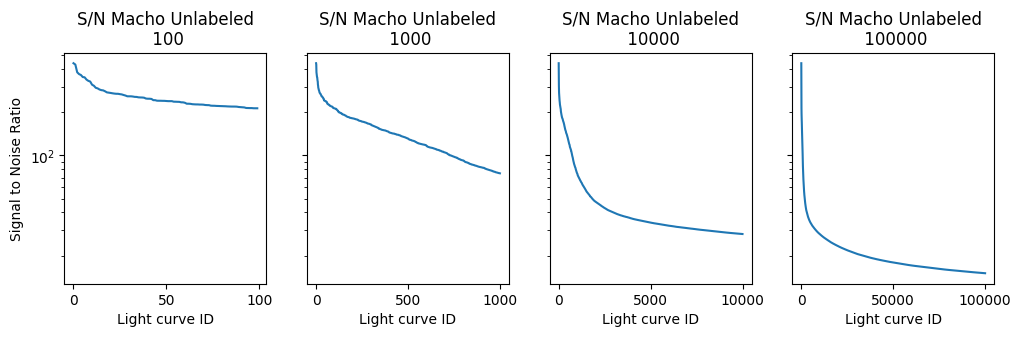

In [57]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharey=True, dpi=100)
for k, num in enumerate([100, 1000, 10000, 100000]):
    selected = rest.iloc[:num]
    axes[k].plot(selected['snr_sqrt'].values)
    axes[k].set_title('S/N Macho Unlabeled\n {}'.format(num))
    axes[k].set_xlabel('Light curve ID')
    axes[k].set_ylabel('Signal to Noise Ratio')
    axes[k].set_yscale('log')
    selected.to_parquet('./data/raw_parquet/macho/metadata_{}.parquet'.format(num))
    if k > 0:
        axes[k].set_ylabel('')
plt.show()